In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("sp500.csv")
#print(df.head())
# Make single variable
#df.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index(['Date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]

In [4]:
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(4227, 5)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
    
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
# Process the data for the shape of the moving window
def ExtractFeatures(sequence, n_steps, window_space=1):
    
    for j in range(sequence.shape[1]):
        mean_seq = []
        variance_seq = []
        skewness_seq = []
        sum_seq = []
        min_seq = []
        max_seq = []
        range_seq = []
        median_seq = []
        iqr_seq = []
        stochastic_oscillator = []
        
        label_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > len(sequence)-1:
                break
            data = sequence[i:end_index, j]
            
            #Average of window
            mean = np.mean(data)
            mean_seq.append(mean)
            #Varience of window
            variance = np.var(data)
            variance_seq.append(variance)
            #Skewness of window
            skewness_seq.append(float(skew(data)))
            #Sum of window
            Sum = np.sum(data)
            sum_seq.append(Sum)
            #Min of window
            Min = np.min(data)
            min_seq.append(Min)
            #Max of window
            Max = np.max(data)
            max_seq.append(Max)
            #Range of window
            Range = Max-Min
            range_seq.append(Range)
            #Median of window
            median = np.median(data)
            median_seq.append(median)
            #IQR of window
            iqr = np.subtract(*np.percentile(data, [75, 25]))
            iqr_seq.append(iqr)
            #Stochastic oscillator
            so = ((data[-1]-Min)/(Range))
            stochastic_oscillator.append(so)
        
        mean_seq = np.array(mean_seq)
        variance_seq = np.array(variance_seq)
        skewness_seq = np.array(skewness_seq)
        sum_seq = np.array(sum_seq)
        min_seq = np.array(min_seq)
        max_seq = np.array(max_seq)
        range_seq = np.array(range_seq)
        median_seq = np.array(median_seq)
        iqr_seq = np.array(iqr_seq)
        stochastic_oscillator = np.array(stochastic_oscillator)

        
        mean_seq = mean_seq.reshape(len(mean_seq),1)
        variance_seq = variance_seq.reshape(len(variance_seq),1)
        skewness_seq = skewness_seq.reshape(len(skewness_seq),1)
        sum_seq = sum_seq.reshape(len(sum_seq),1)
        min_seq = min_seq.reshape(len(min_seq),1)
        max_seq = max_seq.reshape(len(max_seq),1)
        range_seq = range_seq.reshape(len(range_seq),1)
        median_seq = median_seq.reshape(len(median_seq),1)
        iqr_seq = iqr_seq.reshape(len(iqr_seq),1)
        stochastic_oscillator = iqr_seq.reshape(len(stochastic_oscillator),1)
        
        if j == 0:
            features = np.hstack((mean_seq, stochastic_oscillator, median_seq)) 
            
        else:
            features = np.hstack((features, mean_seq, stochastic_oscillator, median_seq)) 
            
    return (features)

In [7]:
def prepareDataset(window_size, window_space):
    #Extract train and test features
    train_features = ExtractFeatures(x_train_scaled, window_size, window_space)
    test_features = ExtractFeatures(x_test_scaled, window_size, window_space)
    train_input, test_input = np.expand_dims(train_features, axis=1), np.expand_dims(test_features, axis=1)

    #Get train and test labels
    train_labels = GetLabels(y_train_scaled, window_size, window_space)
    test_labels = GetLabels(y_test_scaled, window_size, window_space)
    return train_input, test_input, train_labels, test_labels

In [8]:
def LSTMmodel(hidden_size, num_layers, input_shape):
    
    lstm = Sequential()
    lstm.add(LSTM(hidden_size, activation='tanh', input_shape=input_shape, return_sequences=True))
    lstm.add(Dropout(0.2))
    
    for i in range(num_layers-1):
        lstm.add(LSTM(hidden_size, activation='tanh', return_sequences=True))
        lstm.add(Dropout(0.2))
        
    lstm.add(Dense(1, activation='linear'))
    lstm.build()
    return lstm

In [9]:
def FullyConnected(hiddensize, num_layers, input_shape):
    
    fullyconnected = Sequential()
    fullyconnected.add(Dense(hiddensize, input_shape=(input_shape), activation='relu'))
    
    for i in range(num_layers-1):
        fullyconnected.add(Dense(hiddensize//2, activation='relu'))
        
    fullyconnected.add(Dense(1, activation='linear'))
    fullyconnected.build()
    return fullyconnected

In [10]:
def Convolutional(hiddensize, num_layers, input_shape):
    
    cnn = Sequential()
    cnn.add(Conv1D(filters=hiddensize, kernel_size=1, activation='relu', input_shape=(input_shape)))
    cnn.add(MaxPooling1D(pool_size=1))
    
    for i in range(1, num_layers-1):
        cnn.add(Conv1D(filters=hiddensize//(2*i), kernel_size=1, activation='relu'))
        cnn.add(MaxPooling1D(pool_size=1))
        
    cnn.add(Flatten())
    cnn.add(Dense(50, activation='relu'))
    cnn.add(Dense(1))
    return cnn

In [11]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

In [12]:
def plotperformance(history):
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model train vs validation mean absolute error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [13]:
def plotpredictions(model, y_pred, y_labels):
    
    y_pred = model.predict(y_pred)
    y_pred = y_pred.reshape(-1,1)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    y_labels_rescaled = y_scaler.inverse_transform(y_labels)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_labels_rescaled, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    RMSE = np.sqrt(mean_squared_error(y_pred_rescaled, y_labels_rescaled))
    return RMSE

In [14]:
def train_evaluate(ga_individual_solution):
    
    #Decode parameter values from the bit array
    window_size_bits = BitArray(ga_individual_solution[0:8])
    window_space_bits = BitArray(ga_individual_solution[8:11])
    #lstm_size_bits = BitArray(ga_individual_solution[11:22])
    #lstm_layers_bits = BitArray(ga_individual_solution[22:25])
    #FF_size_bits = BitArray(ga_individual_solution[11:22])
    #FF_layers_bits = BitArray(ga_individual_solution[22:25])
    CNN_size_bits = BitArray(ga_individual_solution[11:19])
    CNN_layers_bits = BitArray(ga_individual_solution[19:22])
    epochs_bits = BitArray(ga_individual_solution[22:29])
    batch_size_bits = BitArray(ga_individual_solution[29:])
    
    window_size = window_size_bits.uint
    window_space = window_space_bits.uint
    #lstm_size = lstm_size_bits.uint
    #lstm_layers = lstm_layers_bits.uint
    #FF_size = FF_size_bits.uint
    #FF_layers = FF_layers_bits.uint
    CNN_size = CNN_size_bits.uint
    CNN_layers = CNN_layers_bits.uint
    epochs = epochs_bits.uint
    batch_size = batch_size_bits.uint
    print('\nWindow Size: ', window_size, 'window spacing: ', window_space, 'CNN size', CNN_size, 'CNN layers', CNN_layers, 'epochs', epochs, 'batch size', batch_size)
    
    if window_size == 0 or window_size > 150 or window_space == 0 or CNN_size == 0 or CNN_size > 1500 or epochs < 10 or batch_size == 0 or CNN_layers > 5:
        return 100,

    learning_rate = 0.0001
    
    #Extract train and test features
    train_input, test_input, train_labels, test_labels = prepareDataset(window_size, window_space)

    #Validation Data
    validation_data = (test_input, test_labels)
    
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    input_shape = (train_input.shape[1], train_input.shape[2])
    #model = LSTMmodel(lstm_size, lstm_layers, input_shape)
    #model = FullyConnected(FF_size, FF_layers, input_shape)
    model = Convolutional(CNN_size, CNN_layers, input_shape)

    model.compile(loss=mse, 
                  optimizer=optimiser,
                  metrics=['MAE'])

    model.summary()
    history = model.fit(train_input,
                        train_labels,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        shuffle=False)
    
    plotperformance(history)
    results = model.evaluate(x = test_input,
                             y = test_labels)
    RMSE = plotpredictions(model, test_input, test_labels)
    print('loss(test-set):', results[0])

    return (RMSE,)

In [15]:
def runGeneticAlgorithm():
    population_size = 30
    num_generations = 3
    gene_length = 36

    # Minimising the RMSE score so weights = -1
    creator.create('FitnessMax', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('mate', tools.cxOrdered)
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.6)
    toolbox.register('select', tools.selRoulette)
    toolbox.register('evaluate', train_evaluate)

    population = toolbox.population(n=population_size)
    results = algorithms.eaSimple(population, toolbox, cxpb=0.4, mutpb=0.1, ngen=num_generations, verbose=False)
    
    optimal_individual_data = tools.selBest(population, k=1)
    
    optimal_window_size = None
    optimal_window_space = None
    optimal_CNN_size = None
    optimal_CNN_layers = None
    optimal_epochs = None
    optimal_batch_size = None
    
    for bi in optimal_individual_data:
        window_size_bits = BitArray(bi[0:8])
        window_space_bits = BitArray(bi[8:11])
        #lstm_size_bits = BitArray(bi[11:22])
        #lstm_layers_bits = BitArray(bi[22:25])
        #FF_size_bits = BitArray(bi[11:22])
        #FF_layers_bits = BitArray(bi[22:25])
        CNN_size_bits = BitArray(bi[11:22])
        CNN_layers_bits = BitArray(bi[22:25])
        epochs_bits = BitArray(bi[25:32])
        batch_size_bits = BitArray(bi[32:])
    
        optimal_window_size = window_size_bits.uint
        optimal_window_space = window_space_bits.uint
        #optimal_lstm_size = lstm_size_bits.uint
        #optimal_lstm_layers = lstm_layers_bits.uint
        #optimal_FF_size = FF_size_bits.uint
        #optimal_FF_layers = FF_layers_bits.uint
        optimal_CNN_size = CNN_size_bits.uint
        optimal_CNN_layers = CNN_layers_bits.uint
        optimal_epochs = epochs_bits.uint
        optimal_batch_size = batch_size_bits.uint
        print('\nOptimal_Window Size: ', optimal_window_size, 'Optimal_window spacing: ', optimal_window_space, 'Optimal_CNN size', optimal_CNN_size, 'Optimal_CNN layers', optimal_CNN_layers, 'Optimal_epochs', optimal_epochs, 'Optimal_batch size', optimal_batch_size)



Window Size:  35 window spacing:  3 CNN size 134 CNN layers 0 epochs 98 batch size 106
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 134)            2144      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 134)            0         
_________________________________________________________________
flatten (Flatten)            (None, 134)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6750      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 8,945
Trainable params: 8,945
Non-trainable params: 

1398/1398 [==============================] - 0s 24us/sample - loss: 0.0010 - mean_absolute_error: 0.0246 - val_loss: 0.0042 - val_mean_absolute_error: 0.0574
Epoch 40/98
1398/1398 [==============================] - 0s 23us/sample - loss: 9.9950e-04 - mean_absolute_error: 0.0245 - val_loss: 0.0041 - val_mean_absolute_error: 0.0568
Epoch 41/98
1398/1398 [==============================] - 0s 22us/sample - loss: 9.9271e-04 - mean_absolute_error: 0.0244 - val_loss: 0.0041 - val_mean_absolute_error: 0.0563
Epoch 42/98
1398/1398 [==============================] - 0s 23us/sample - loss: 9.8608e-04 - mean_absolute_error: 0.0243 - val_loss: 0.0040 - val_mean_absolute_error: 0.0557
Epoch 43/98
1398/1398 [==============================] - 0s 23us/sample - loss: 9.7967e-04 - mean_absolute_error: 0.0242 - val_loss: 0.0039 - val_mean_absolute_error: 0.0552
Epoch 44/98
1398/1398 [==============================] - 0s 23us/sample - loss: 9.7344e-04 - mean_absolute_error: 0.0241 - val_loss: 0.0039 - val_

1398/1398 [==============================] - 0s 24us/sample - loss: 8.3812e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0439
Epoch 87/98
1398/1398 [==============================] - 0s 25us/sample - loss: 8.3689e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0439
Epoch 88/98
1398/1398 [==============================] - 0s 24us/sample - loss: 8.3572e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0438
Epoch 89/98
1398/1398 [==============================] - 0s 24us/sample - loss: 8.3458e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0437
Epoch 90/98
1398/1398 [==============================] - 0s 24us/sample - loss: 8.3347e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0027 - val_mean_absolute_error: 0.0436
Epoch 91/98
1398/1398 [==============================] - 0s 24us/sample - loss: 8.3236e-04 - mean_absolute_error: 0.0220 - val_loss: 0.0026 - 

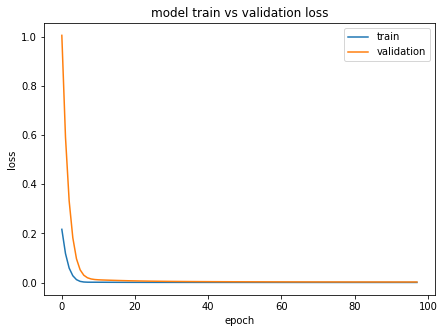

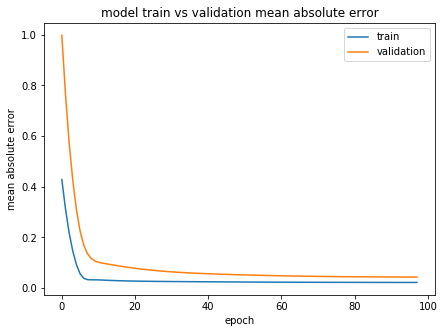

145/145 [==============================] - 0s 76us/sample - loss: 0.0026 - mean_absolute_error: 0.0430


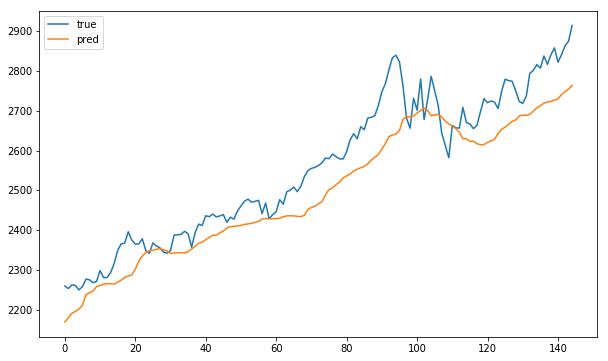

loss(test-set): 0.002585984795386421

Window Size:  199 window spacing:  1 CNN size 202 CNN layers 5 epochs 22 batch size 37

Window Size:  38 window spacing:  2 CNN size 134 CNN layers 2 epochs 57 batch size 11
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 134)            2144      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 134)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 134)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6750      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 8,945
Trainable params: 8,945
Non-trainable para

2095/2095 [==============================] - 0s 188us/sample - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0018 - val_mean_absolute_error: 0.0347
Epoch 42/57
2095/2095 [==============================] - 0s 188us/sample - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0017 - val_mean_absolute_error: 0.0340
Epoch 43/57
2095/2095 [==============================] - 0s 183us/sample - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0016 - val_mean_absolute_error: 0.0335
Epoch 44/57
2095/2095 [==============================] - 0s 187us/sample - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0016 - val_mean_absolute_error: 0.0330
Epoch 45/57
2095/2095 [==============================] - 0s 187us/sample - loss: 0.0011 - mean_absolute_error: 0.0262 - val_loss: 0.0016 - val_mean_absolute_error: 0.0330
Epoch 46/57
2095/2095 [==============================] - 0s 184us/sample - loss: 0.0011 - mean_absolute_error: 0.0261 - val_loss: 0.0016 - val_mean_absolute_

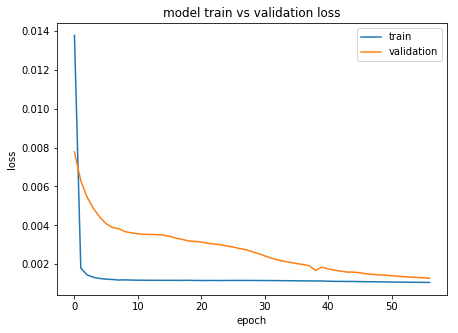

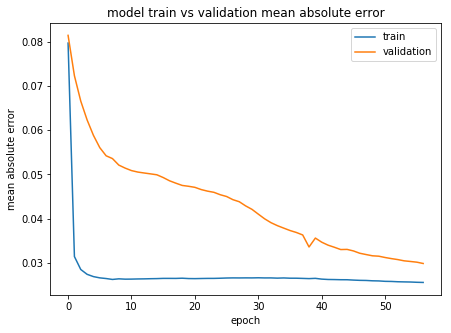

216/216 [==============================] - 0s 46us/sample - loss: 0.0013 - mean_absolute_error: 0.0298


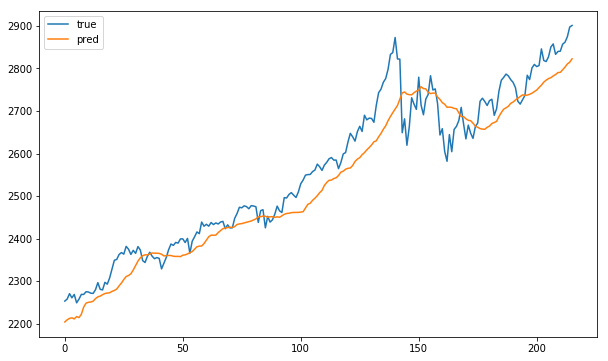

loss(test-set): 0.001279481548677992

Window Size:  72 window spacing:  7 CNN size 85 CNN layers 3 epochs 58 batch size 43
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 85)             1360      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 85)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 42)             3612      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 42)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2150      
___________________

594/594 [==============================] - 0s 64us/sample - loss: 0.0015 - mean_absolute_error: 0.0294 - val_loss: 0.0042 - val_mean_absolute_error: 0.0580
Epoch 42/58
594/594 [==============================] - 0s 66us/sample - loss: 0.0015 - mean_absolute_error: 0.0293 - val_loss: 0.0041 - val_mean_absolute_error: 0.0572
Epoch 43/58
594/594 [==============================] - 0s 64us/sample - loss: 0.0015 - mean_absolute_error: 0.0292 - val_loss: 0.0040 - val_mean_absolute_error: 0.0563
Epoch 44/58
594/594 [==============================] - 0s 66us/sample - loss: 0.0015 - mean_absolute_error: 0.0291 - val_loss: 0.0039 - val_mean_absolute_error: 0.0556
Epoch 45/58
594/594 [==============================] - 0s 62us/sample - loss: 0.0015 - mean_absolute_error: 0.0291 - val_loss: 0.0039 - val_mean_absolute_error: 0.0551
Epoch 46/58
594/594 [==============================] - 0s 66us/sample - loss: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0038 - val_mean_absolute_error: 0.0546
Epoc

KeyboardInterrupt: 

In [16]:
runGeneticAlgorithm()